In [1]:
from datasets import load_dataset
from torch.cuda.amp import autocast, GradScaler

In [2]:
#Libraries First:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#PyTorch Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms.v2 as transforms

from torch.utils.data import Dataset, DataLoader


In [3]:
import os
from PIL import Image
import re

In [4]:
import random
from collections import Counter


## Data loading and Class naming

First we are going to load the data from Hugging face and make a class for loading and augmenting the data with transformers for both the train and valid dataset. The dataset can be found at the following URL: https://huggingface.co/datasets/ethz/food101


In [5]:
dataset = load_dataset("ethz/food101") 


Lets create a class to get the images and labels from the dataset. With Hugging Face the data is different from what we have worked with in class in how it is uploaded so I had to figure out a way to do the getitem differently with 

In [6]:
class Food101Dataset(Dataset):
    
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        image = sample['image'].convert('RGB')  
        label = sample['label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [7]:
# Setup transfromers

# We will resize, change the brightness/contrast, do rotations and Randomm  Horiz flips
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=.3),
    transforms.ToTensor()
])

valid_transform= transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


C:\Users\Kevin\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Data preprocessing

Here we will get the dataset label names from their ID's on the huggingface dataset. Then we will get a subset of data for our CNN that we will run our model on due to training time constraints. Next we will utilize the full dataset (or a larger sample of data) to train our more complex neural network on

In [8]:
# Get the label names to id from hugging face, then switch the id and label
label_id = {
  "apple_pie": 0,
  "baby_back_ribs": 1,
  "baklava": 2,
  "beef_carpaccio": 3,
  "beef_tartare": 4,
  "beet_salad": 5,
  "beignets": 6,
  "bibimbap": 7,
  "bread_pudding": 8,
  "breakfast_burrito": 9,
  "bruschetta": 10,
  "caesar_salad": 11,
  "cannoli": 12,
  "caprese_salad": 13,
  "carrot_cake": 14,
  "ceviche": 15,
  "cheesecake": 16,
  "cheese_plate": 17,
  "chicken_curry": 18,
  "chicken_quesadilla": 19,
  "chicken_wings": 20,
  "chocolate_cake": 21,
  "chocolate_mousse": 22,
  "churros": 23,
  "clam_chowder": 24,
  "club_sandwich": 25,
  "crab_cakes": 26,
  "creme_brulee": 27,
  "croque_madame": 28,
  "cup_cakes": 29,
  "deviled_eggs": 30,
  "donuts": 31,
  "dumplings": 32,
  "edamame": 33,
  "eggs_benedict": 34,
  "escargots": 35,
  "falafel": 36,
  "filet_mignon": 37,
  "fish_and_chips": 38,
  "foie_gras": 39,
  "french_fries": 40,
  "french_onion_soup": 41,
  "french_toast": 42,
  "fried_calamari": 43,
  "fried_rice": 44,
  "frozen_yogurt": 45,
  "garlic_bread": 46,
  "gnocchi": 47,
  "greek_salad": 48,
  "grilled_cheese_sandwich": 49,
  "grilled_salmon": 50,
  "guacamole": 51,
  "gyoza": 52,
  "hamburger": 53,
  "hot_and_sour_soup": 54,
  "hot_dog": 55,
  "huevos_rancheros": 56,
  "hummus": 57,
  "ice_cream": 58,
  "lasagna": 59,
  "lobster_bisque": 60,
  "lobster_roll_sandwich": 61,
  "macaroni_and_cheese": 62,
  "macarons": 63,
  "miso_soup": 64,
  "mussels": 65,
  "nachos": 66,
  "omelette": 67,
  "onion_rings": 68,
  "oysters": 69,
  "pad_thai": 70,
  "paella": 71,
  "pancakes": 72,
  "panna_cotta": 73,
  "peking_duck": 74,
  "pho": 75,
  "pizza": 76,
  "pork_chop": 77,
  "poutine": 78,
  "prime_rib": 79,
  "pulled_pork_sandwich": 80,
  "ramen": 81,
  "ravioli": 82,
  "red_velvet_cake": 83,
  "risotto": 84,
  "samosa": 85,
  "sashimi": 86,
  "scallops": 87,
  "seaweed_salad": 88,
  "shrimp_and_grits": 89,
  "spaghetti_bolognese": 90,
  "spaghetti_carbonara": 91,
  "spring_rolls": 92,
  "steak": 93,
  "strawberry_shortcake": 94,
  "sushi": 95,
  "tacos": 96,
  "takoyaki": 97,
  "tiramisu": 98,
  "tuna_tartare": 99,
  "waffles": 100
}

In [9]:
# swithc the label and IDs so the IDs are first 
id_to_label = {v: k for k, v in label_id.items()}


In [10]:
#define a function to be abel to map our dataset to 
def label_name(example):
    example['label_name'] = id_to_label[example['label']]
    return example

# Apply to the dataset
dataset = dataset.map(label_name)

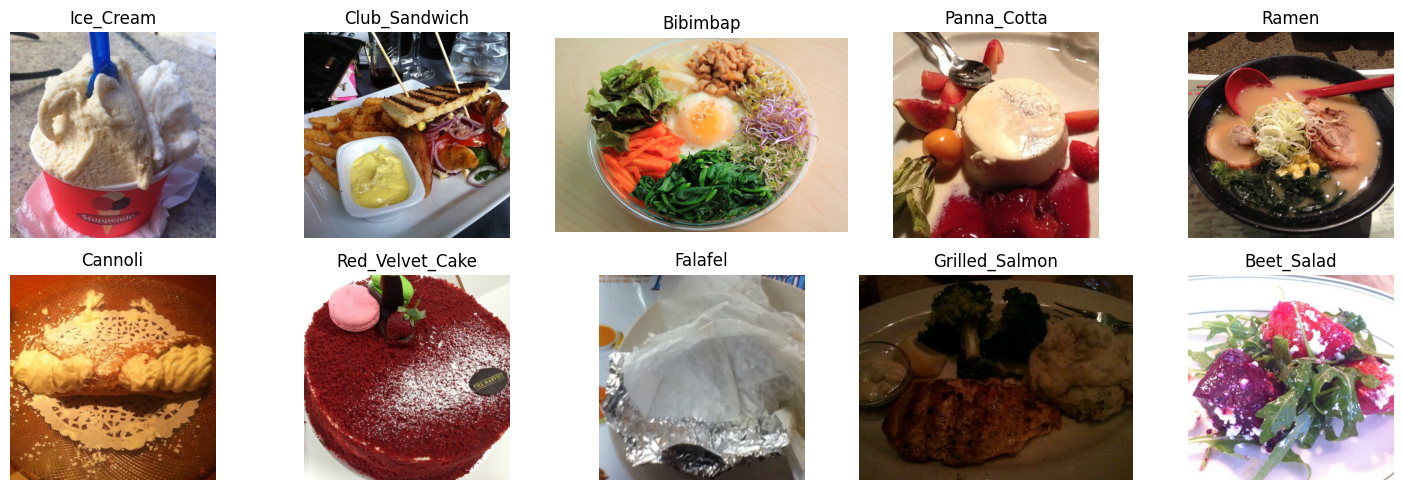

In [11]:
#Test on images and show if it worked
indices = random.sample(range(len(dataset['train'])), 10)

plt.figure(figsize=(15, 5))
for i, j in enumerate(indices):
    image = dataset['train'][j]['image']
    label_name = dataset['train'][j]['label_name']

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(label_name.title())
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
#determine image size of all images
print(image.size)

(512, 512)


# Subset data

Due to the time requirements of training runs we are only going to work on 20 classes. This is a diverse enough dataset that 20 classes with 1,000 images per class will be enough without having an extended period for training runs.

In [13]:
# We will start by doing a sub sample of 20 labels in our classes
selected_classes = ["apple_pie","baby_back_ribs","baklava", "beef_carpaccio","beef_tartare",
                    "beet_salad","beignets","bibimbap","bread_pudding","breakfast_burrito",
                    "bruschetta","caesar_salad","cannoli","caprese_salad","carrot_cake",
                    "ceviche","cheesecake","cheese_plate","chicken_curry","chicken_quesadilla"]

def filtered(lbl):
    return dataset['train'].features['label'].int2str(lbl['label']) in selected_classes

In [15]:
subset_train = dataset['train'].filter(filtered)
subset_val = dataset['validation'].filter(filtered)


Filter:   0%|          | 0/75750 [00:00<?, ? examples/s]

C:\Users\Kevin\anaconda3\envs\torch_gpu\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Filter:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [16]:
train_labels = [dataset['train'].features['label'].int2str(x['label']) for x in subset_train]
val_labels = [dataset['validation'].features['label'].int2str(x['label']) for x in subset_val]

print("Train label counts:", Counter(train_labels))
print("Val label counts:", Counter(val_labels))

Train label counts: Counter({'beignets': 750, 'bruschetta': 750, 'apple_pie': 750, 'carrot_cake': 750, 'beet_salad': 750, 'caesar_salad': 750, 'cheesecake': 750, 'baklava': 750, 'breakfast_burrito': 750, 'beef_tartare': 750, 'chicken_quesadilla': 750, 'beef_carpaccio': 750, 'cheese_plate': 750, 'bread_pudding': 750, 'chicken_curry': 750, 'caprese_salad': 750, 'baby_back_ribs': 750, 'bibimbap': 750, 'ceviche': 750, 'cannoli': 750})
Val label counts: Counter({'beignets': 250, 'bruschetta': 250, 'apple_pie': 250, 'carrot_cake': 250, 'beet_salad': 250, 'caesar_salad': 250, 'cheesecake': 250, 'baklava': 250, 'breakfast_burrito': 250, 'beef_tartare': 250, 'chicken_quesadilla': 250, 'beef_carpaccio': 250, 'cheese_plate': 250, 'bread_pudding': 250, 'chicken_curry': 250, 'caprese_salad': 250, 'baby_back_ribs': 250, 'bibimbap': 250, 'ceviche': 250, 'cannoli': 250})


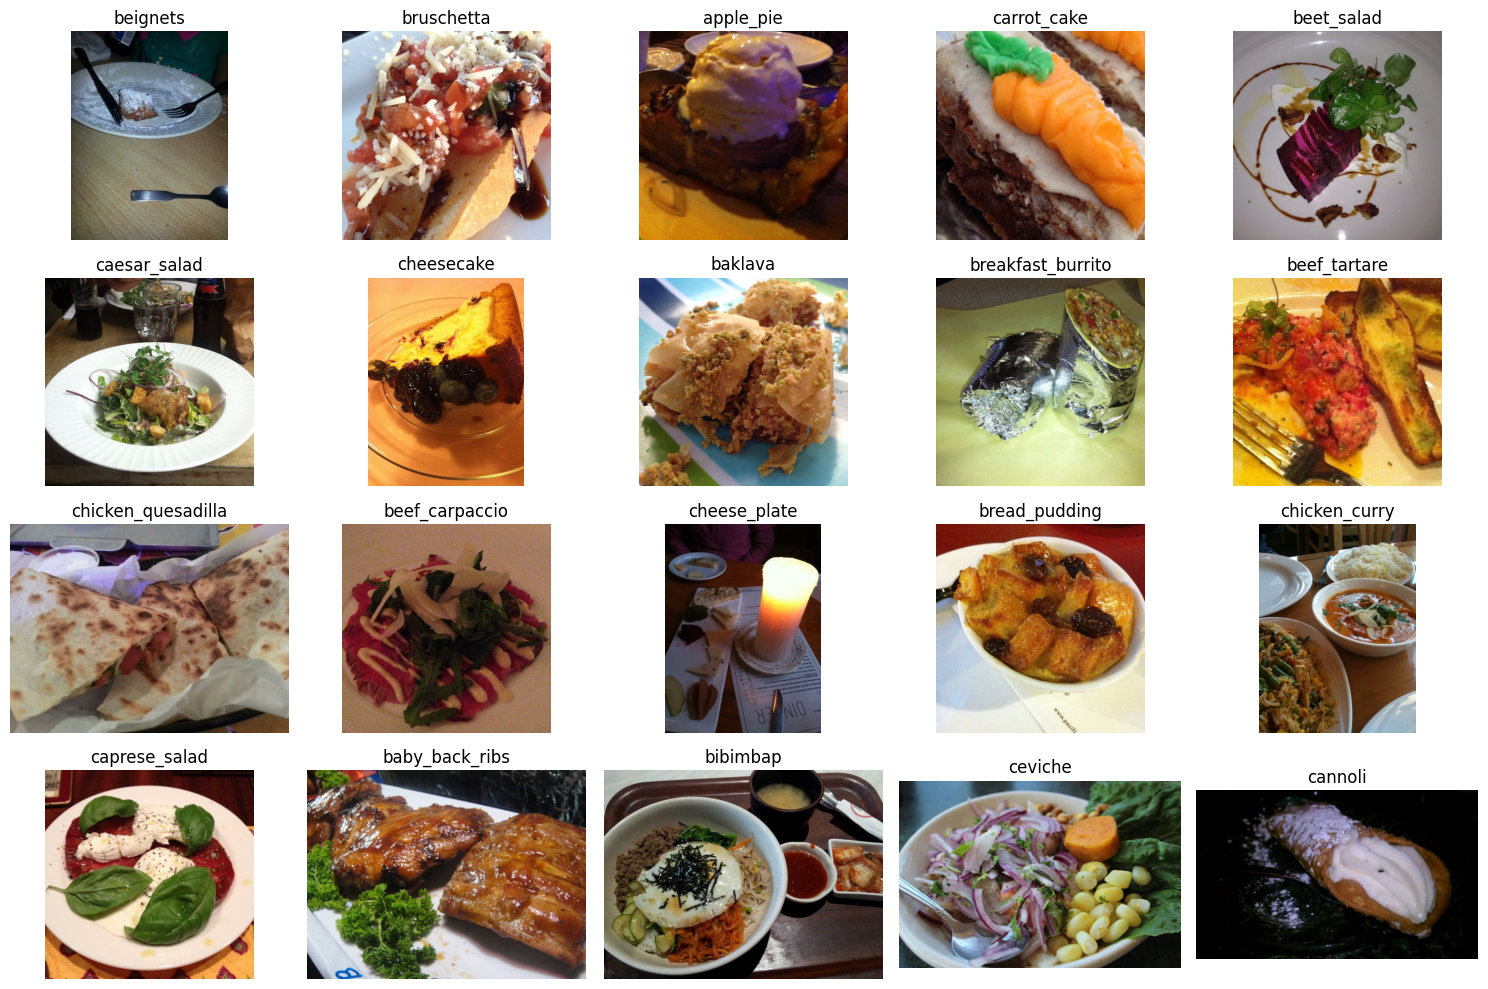

In [17]:
# For decoding integer label to class name
int2str = subset_train.features['label'].int2str

# Track which classes we've shown
seen = set()
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

i = 0
for example in subset_train:
    label_name = int2str(example['label'])
    if label_name not in seen:
        axes[i].imshow(example['image'])
        axes[i].set_title(label_name)
        axes[i].axis('off')
        seen.add(label_name)
        i += 1
    if i == 20:
        break

plt.tight_layout()
plt.show()


In [18]:
# create the datasets we are going to use for the training and val
train_dataset = Food101Dataset(data = subset_train, transform=train_transform)
valid_dataset = Food101Dataset(data = subset_val, transform=valid_transform)

In [19]:
# Create the dataloaders
#Data Loader
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle= True)
valid_loader = DataLoader(valid_dataset, batch_size = 128, shuffle= True)

## Convolutional Neural Network

Next we will make the CNN from scratch. This will be our baseline that we use. This will help us to benchmark against the more complex models later on. 

In [25]:
class ScratchCNN(nn.Module):
    def __init__(self):

        super().__init__()

        #Layer 1
        self.conv1 = nn.Conv2d(3,16, (4,4), stride = 2, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d((2,2), stride = 2)

        #layer 2
        self.conv2 = nn.Conv2d(16,32, (3,3), stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64, (3,3), stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d((2,2), stride = 2)
        
        #activation function
        self.relu = nn.ReLU()

        
        #FC layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*8*8, 256)
        self.dropout = nn.Dropout(p=.5)
        self.fc2 = nn.Linear(256,20)

    
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = torch.flatten(x, start_dim =1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## Setup

We will introduce the loss function and optimizer to be SGD with cross entropy loss function. With the CNN we will do 20 epochs. Previously we ran less epochs under the training and it ran well so we increased the epoch count. 
To help speed up training we will add the gpu with torch.device

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn = ScratchCNN().to(device)
model_cnn.conv1.weight.shape
torch.cuda.empty_cache()

In [27]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cnn.parameters(), lr= .01, momentum = .9)

In [28]:
epochs = 20
train_accuracy_history = []
val_accuracy_history = []

scaler = GradScaler()

for epoch in range(epochs):
    model_cnn.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_cnn(images)
            loss = loss_function(outputs,labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Track loss
        running_loss += loss.item()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        running_correct += (predicted == labels).sum().item()
        running_total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * (running_correct / running_total)
    train_accuracy_history.append(train_acc)

    model_cnn.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_cnn(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * (val_correct / val_total)
    val_accuracy_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}% \n"
          f"Val Loss: {val_loss / len(valid_loader):.4f}  Val Acc: {val_acc:.2f}%\n")

C:\Users\Kevin\AppData\Local\Temp\ipykernel_27456\1363689075.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\Kevin\AppData\Local\Temp\ipykernel_27456\1363689075.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/20] Train Loss: 2.8184  Train Acc: 13.67% 
Val Loss: 2.6087  Val Acc: 21.50%

Epoch [2/20] Train Loss: 2.6764  Train Acc: 18.04% 
Val Loss: 2.4697  Val Acc: 24.96%

Epoch [3/20] Train Loss: 2.5876  Train Acc: 20.31% 
Val Loss: 2.3971  Val Acc: 25.34%

Epoch [4/20] Train Loss: 2.5227  Train Acc: 22.12% 
Val Loss: 2.5057  Val Acc: 23.56%

Epoch [5/20] Train Loss: 2.4617  Train Acc: 24.38% 
Val Loss: 2.3795  Val Acc: 27.80%

Epoch [6/20] Train Loss: 2.4039  Train Acc: 25.59% 
Val Loss: 2.4054  Val Acc: 26.40%

Epoch [7/20] Train Loss: 2.3468  Train Acc: 27.14% 
Val Loss: 2.5818  Val Acc: 24.48%

Epoch [8/20] Train Loss: 2.2941  Train Acc: 28.74% 
Val Loss: 2.2230  Val Acc: 30.60%

Epoch [9/20] Train Loss: 2.2387  Train Acc: 30.33% 
Val Loss: 2.3301  Val Acc: 29.96%

Epoch [10/20] Train Loss: 2.1819  Train Acc: 32.40% 
Val Loss: 2.1515  Val Acc: 32.06%

Epoch [11/20] Train Loss: 2.1391  Train Acc: 34.11% 
Val Loss: 2.0904  Val Acc: 35.50%

Epoch [12/20] Train Loss: 2.0892  Train A

In [29]:
#Print the Final Training and Validation accuracy
print("The Final Training Accuracy:")
print(f'{train_accuracy_history[-1]: .2f}')
print("The Final Validation Accuracy:")
print(f'{val_accuracy_history[-1]: .2f}%')

The Final Training Accuracy:
 46.52
The Final Validation Accuracy:
 43.84%


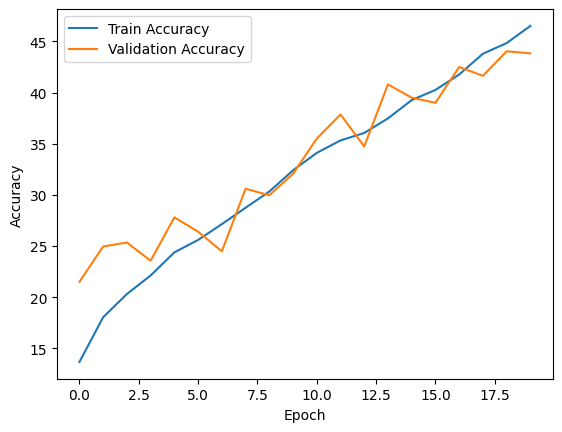

In [30]:
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Complex Model 

In this next section we are going to import a ResNet18, VGG16, and Efficientnet_b0 models from PyTorch and freeze all layers except the output layer to do our next training run. These models are more robust and pretrained with different images so this may or may not work out for better accuracy.

In [31]:
# Import the ResNet18 model from PyTorch
resnet18 = models.resnet18(pretrained=True)

C:\Users\Kevin\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kevin\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
for param in resnet18.parameters():
    param.requires_grad = False

In [33]:
# Change the output laye
num_classes = 20
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

In [35]:
# move it to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

In [36]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.fc.parameters(), lr=0.001)


In [37]:
epochs = 15
train_accuracy_history = []
val_accuracy_history = []

scaler = GradScaler()

for epoch in range(epochs):
    resnet18.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = resnet18(images)
            loss = loss_function(outputs,labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Track loss
        running_loss += loss.item()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        running_correct += (predicted == labels).sum().item()
        running_total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * (running_correct / running_total)
    train_accuracy_history.append(train_acc)

    resnet18.eval()
    val_correct = 0.0
    val_total = 0.0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * (val_correct / val_total)
    val_accuracy_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}% \n"
          f"Val Loss: {val_loss / len(valid_loader):.4f}  Val Acc: {val_acc:.2f}%\n")

C:\Users\Kevin\AppData\Local\Temp\ipykernel_27456\2528280592.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\Kevin\AppData\Local\Temp\ipykernel_27456\2528280592.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/15] Train Loss: 2.6467  Train Acc: 21.24% 
Val Loss: 2.3404  Val Acc: 30.84%

Epoch [2/15] Train Loss: 2.3102  Train Acc: 31.07% 
Val Loss: 2.2431  Val Acc: 34.04%

Epoch [3/15] Train Loss: 2.2234  Train Acc: 33.43% 
Val Loss: 2.2431  Val Acc: 34.38%

Epoch [4/15] Train Loss: 2.1841  Train Acc: 34.89% 
Val Loss: 2.2350  Val Acc: 34.40%

Epoch [5/15] Train Loss: 2.1615  Train Acc: 35.32% 
Val Loss: 2.2220  Val Acc: 35.20%

Epoch [6/15] Train Loss: 2.1501  Train Acc: 35.65% 
Val Loss: 2.2177  Val Acc: 33.76%

Epoch [7/15] Train Loss: 2.1268  Train Acc: 36.40% 
Val Loss: 2.2337  Val Acc: 34.74%

Epoch [8/15] Train Loss: 2.1275  Train Acc: 36.48% 
Val Loss: 2.2116  Val Acc: 34.54%

Epoch [9/15] Train Loss: 2.1182  Train Acc: 36.77% 
Val Loss: 2.2330  Val Acc: 33.74%

Epoch [10/15] Train Loss: 2.1058  Train Acc: 36.67% 
Val Loss: 2.1947  Val Acc: 34.82%

Epoch [11/15] Train Loss: 2.0939  Train Acc: 36.92% 
Val Loss: 2.2483  Val Acc: 33.26%

Epoch [12/15] Train Loss: 2.1104  Train A

In [38]:
print("The Final Train Accuracy:")
print(f'{train_accuracy_history[-1]: .2f}%')
print("The Final Validation Accuracy:")
print(f'{val_accuracy_history[-1]: .2f}%')

The Final Validation Accuracy:
 37.07%
The Final Validation Accuracy:
 34.86%


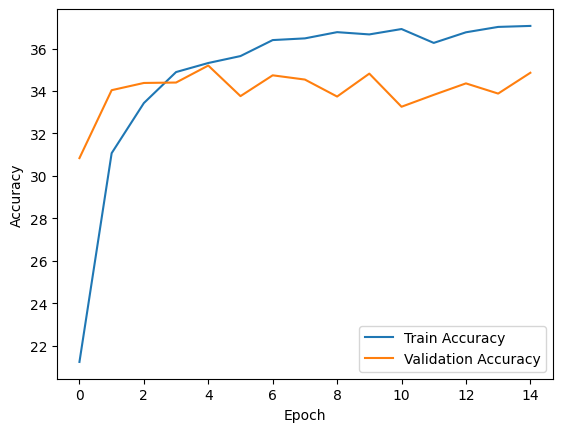

In [39]:
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

C:\Users\Kevin\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 20)
vgg16 = vgg16.to(device)

In [42]:
optimizer = torch.optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [43]:
epochs = 15
train_accuracy_history = []
val_accuracy_history = []

scaler = GradScaler()

for epoch in range(epochs):
    vgg16.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = vgg16(images)
            loss = loss_function(outputs,labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Track loss
        running_loss += loss.item()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        running_correct += (predicted == labels).sum().item()
        running_total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * (running_correct / running_total)
    train_accuracy_history.append(train_acc)

    vgg16.eval()
    val_correct = 0.0
    val_total = 0.0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * (val_correct / val_total)
    val_accuracy_history.append(val_acc)

    print(f"Epoch [{epoch+ 1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}% \n"
          f"            Val Loss: {val_loss / len(valid_loader):.4f}  Val Acc: {val_acc:.2f}%\n")

C:\Users\Kevin\AppData\Local\Temp\ipykernel_27456\1895376609.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\Kevin\AppData\Local\Temp\ipykernel_27456\1895376609.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/15] Train Loss: 2.5899  Train Acc: 25.00% 
            Val Loss: 2.1431  Val Acc: 34.62%

Epoch [2/15] Train Loss: 2.4269  Train Acc: 29.57% 
            Val Loss: 2.1223  Val Acc: 35.84%

Epoch [3/15] Train Loss: 2.4089  Train Acc: 30.48% 
            Val Loss: 2.1337  Val Acc: 35.46%

Epoch [4/15] Train Loss: 2.3652  Train Acc: 31.54% 
            Val Loss: 2.1170  Val Acc: 36.26%

Epoch [5/15] Train Loss: 2.3521  Train Acc: 31.95% 
            Val Loss: 2.1376  Val Acc: 35.20%

Epoch [6/15] Train Loss: 2.3584  Train Acc: 32.22% 
            Val Loss: 2.1224  Val Acc: 36.16%

Epoch [7/15] Train Loss: 2.3587  Train Acc: 32.49% 
            Val Loss: 2.1538  Val Acc: 34.64%

Epoch [8/15] Train Loss: 2.3348  Train Acc: 33.45% 
            Val Loss: 2.1617  Val Acc: 34.84%

Epoch [9/15] Train Loss: 2.3470  Train Acc: 33.02% 
            Val Loss: 2.1223  Val Acc: 35.40%

Epoch [10/15] Train Loss: 2.3465  Train Acc: 32.96% 
            Val Loss: 2.1109  Val Acc: 35.82%

Epoch [11

In [44]:
print("The Final Train Accuracy:")
print(f'{train_accuracy_history[-1]: .2f}%')
print("The Final Validation Accuracty:")
print(f'{val_accuracy_history[-1]: .2f}%')

The Final Validation Accuracy:
 34.39%
The Final Validation Accuracty:
 35.70%


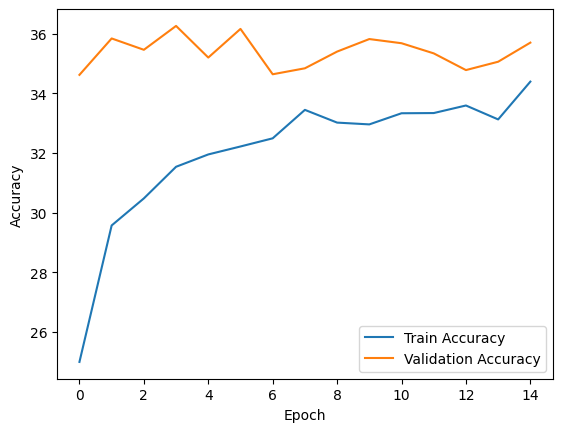

In [45]:
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
from torchvision.models import efficientnet_b0
efficientnet = efficientnet_b0(pretrained=True)


C:\Users\Kevin\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
for param in efficientnet.parameters():
    param.requires_grad = False

In [48]:
num_classes = 20
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, num_classes)

In [49]:
efficientnet = efficientnet.to(device)

In [50]:
optimizer = torch.optim.Adam(efficientnet.classifier[1].parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [51]:
epochs = 15
train_accuracy_history = []
val_accuracy_history = []

scaler = GradScaler()

for epoch in range(epochs):
    efficientnet.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        #with autocast():
        #    outputs = efficientnet(images)
        #    loss = loss_function(outputs,labels)
        outputs = efficientnet(images)
        loss = loss_function(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Track loss
        running_loss += loss.item()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        running_correct += (predicted == labels).sum().item()
        running_total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * (running_correct / running_total)
    train_accuracy_history.append(train_acc)

    efficientnet.eval()
    val_correct = 0.0
    val_total = 0.0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * (val_correct / val_total)
    val_accuracy_history.append(val_acc)

    print(f"Epoch [{epoch+ 1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}% \n"
          f"              Val Loss: {val_loss / len(valid_loader):.4f}  Val Acc: {val_acc:.2f}%\n")

C:\Users\Kevin\AppData\Local\Temp\ipykernel_27456\1215502072.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch [1/15] Train Loss: 2.6178  Train Acc: 21.35% 
              Val Loss: 2.3312  Val Acc: 30.18%

Epoch [2/15] Train Loss: 2.3668  Train Acc: 29.08% 
              Val Loss: 2.2820  Val Acc: 31.90%

Epoch [3/15] Train Loss: 2.3172  Train Acc: 30.43% 
              Val Loss: 2.2676  Val Acc: 31.90%

Epoch [4/15] Train Loss: 2.3027  Train Acc: 31.39% 
              Val Loss: 2.2746  Val Acc: 31.42%

Epoch [5/15] Train Loss: 2.2747  Train Acc: 31.52% 
              Val Loss: 2.2945  Val Acc: 31.54%

Epoch [6/15] Train Loss: 2.2694  Train Acc: 32.32% 
              Val Loss: 2.2899  Val Acc: 31.56%

Epoch [7/15] Train Loss: 2.2643  Train Acc: 31.70% 
              Val Loss: 2.3089  Val Acc: 31.12%

Epoch [8/15] Train Loss: 2.2601  Train Acc: 32.17% 
              Val Loss: 2.2971  Val Acc: 31.10%

Epoch [9/15] Train Loss: 2.2441  Train Acc: 32.67% 
              Val Loss: 2.3130  Val Acc: 30.70%

Epoch [10/15] Train Loss: 2.2479  Train Acc: 33.03% 
              Val Loss: 2.3248  Val Ac

In [52]:
print("The Final Train Accuracy:")
print(f'{train_accuracy_history[-1]: .2f}%')
print("The Final Validation Accuracty:")
print(f'{val_accuracy_history[-1]: .2f}%')

The Final Validation Accuracy:
 32.78%
The Final Validation Accuracty:
 31.18%


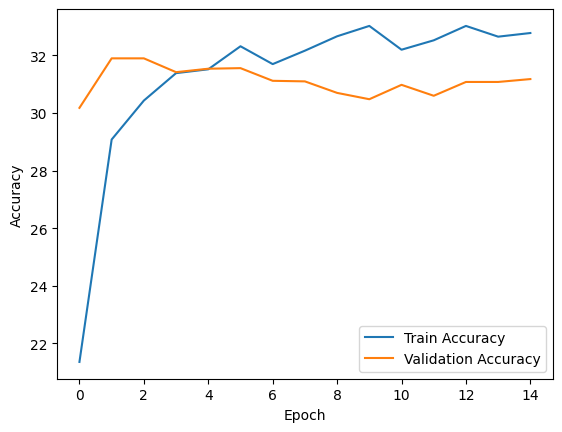

In [53]:
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Visualizations

We are going to visualize the accuracy and loss for each of the models. Unfortunately we did not save the unique variable names for each model but luckily we printed out the entire epoch training/validation loss and accuracy. We will extract these numbers and put them into their own unique variables down here below to plot them by epoch.

In [56]:
train_loss_scratchCNN = [2.8184, 2.6764, 2.5876, 2.5227, 2.4617, 2.4039,
                         2.3468, 2.2941, 2.2387, 2.1819, 2.1391, 2.0892,
                         2.0490, 2.0067, 1.9511,1.9268, 1.8660, 1.7933, 
                        1.7736, 1.7200]
val_loss_scratchCNN = [2.6087, 2.4697, 2.3971, 2.5057, 2.3795,2.4054,
                       2.5818, 2.2230, 2.3301, 2.1515,2.0904, 1.9784, 
                       2.0864, 1.8958, 1.9710,1.9861, 1.8510, 1.8603, 
                       1.8429, 1.7936]

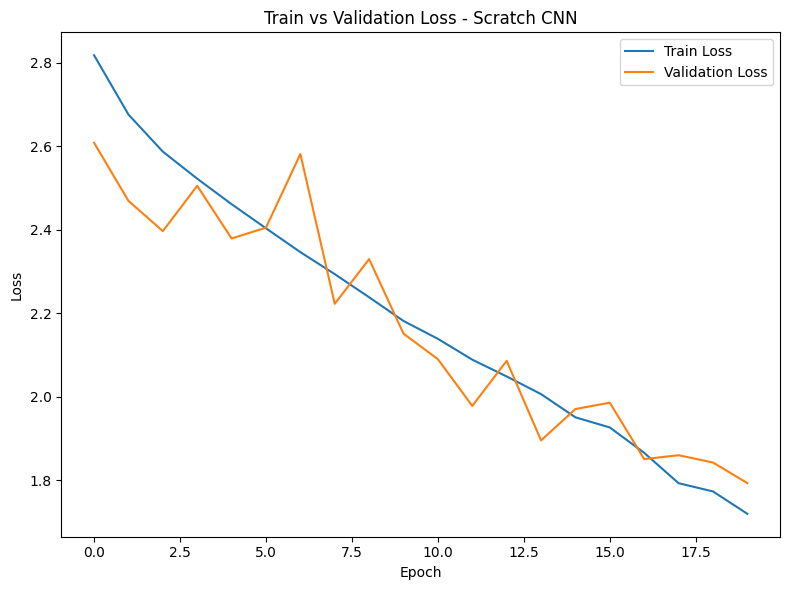

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_scratchCNN, label='Train Loss')
plt.plot(val_loss_scratchCNN, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss - Scratch CNN')
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
# Get loss for resnet
train_loss_resnet= [2.6467, 2.3102, 2.2234, 2.1841, 2.1615,2.1501,
                    2.1268, 2.1275, 2.1182, 2.1058,2.0939, 2.1104, 
                    2.1002, 2.0877, 2.0898]
val_loss_resnet = [2.3404, 2.2431, 2.2431, 2.2350, 2.2220,2.2177, 
                   2.2337, 2.2116, 2.2330, 2.1947,2.2483, 2.2456, 
                   2.2373, 2.2406, 2.2434]
#loss for VGG
train_loss_vgg = [2.5899, 2.4269, 2.4089, 2.3652, 2.3521,2.3584,
                  2.3587, 2.3348, 2.3470, 2.3465,2.3420, 2.3459, 
                  2.3479, 2.3574, 2.3032]
val_loss_vgg = [2.1431, 2.1223, 2.1337, 2.1170, 2.1376,2.1224, 
                2.1538, 2.1617, 2.1223, 2.1109,2.1462, 2.1544, 
                2.1338, 2.1712, 2.1651]
#Loss for efficientnet
train_loss_efficientnet =[2.6178, 2.3668, 2.3172, 2.3027, 2.2747,
                           2.2694, 2.2643, 2.2601, 2.2441, 2.2479,
                           2.2645, 2.2590, 2.2395, 2.2487, 2.2577]
val_loss_efficientnet = [2.3312, 2.2820, 2.2676, 2.2746, 2.2945,2.2899,
                        2.3089, 2.2971, 2.3130, 2.3248,2.3013, 2.3402, 
                        2.3166, 2.3446, 2.3017 ]

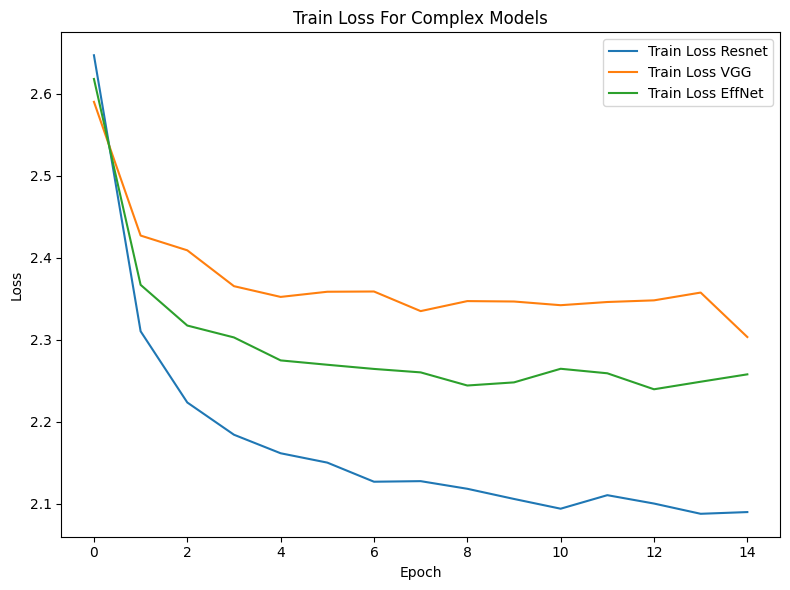

In [60]:
#plot the 3 training losses on a chart

plt.figure(figsize=(8, 6))
plt.plot(train_loss_resnet, label='Train Loss Resnet')
plt.plot(train_loss_vgg, label='Train Loss VGG')
plt.plot(train_loss_efficientnet, label='Train Loss EffNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss For Complex Models')
plt.legend()
plt.tight_layout()
plt.show()

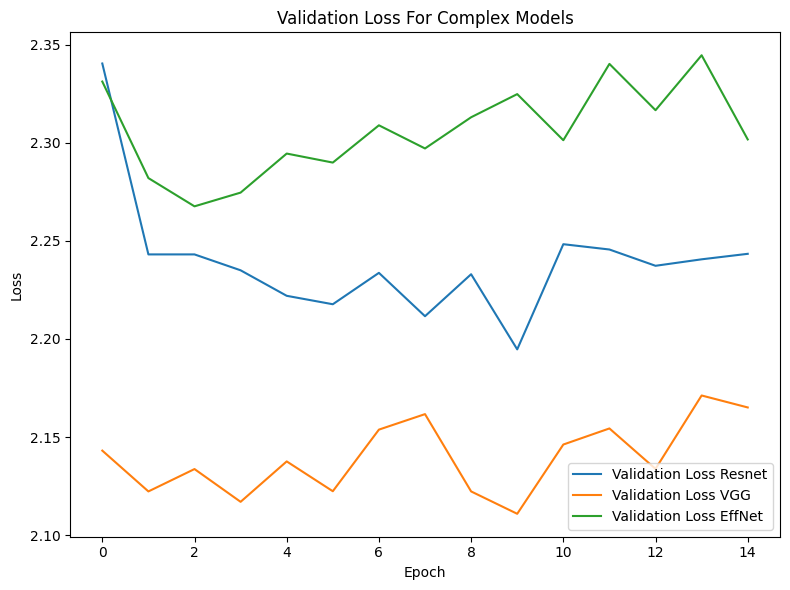

In [61]:
#plot the 3 complex validation losses on a chart

plt.figure(figsize=(8, 6))
plt.plot(val_loss_resnet, label='Validation Loss Resnet')
plt.plot(val_loss_vgg, label='Validation Loss VGG')
plt.plot(val_loss_efficientnet, label='Validation Loss EffNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss For Complex Models')
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
train_acc_scratchCNN = [13.67, 18.04, 20.31, 22.12, 24.38, 25.59, 27.14, 
                        28.74, 30.33, 32.40,34.11, 35.33, 36.05, 37.48, 
                        39.27, 40.26, 41.77, 43.80, 44.84, 46.52]
val_acc_scratchCNN = [21.50, 24.96, 25.34, 23.56, 27.80, 26.40, 24.48, 
                      30.60, 29.96, 32.06, 35.50, 37.86, 34.74, 40.80, 39.50, 
                      39.00, 42.50, 41.64, 44.04, 43.84]
train_acc_resnet = [21.24, 31.07, 33.43, 34.89, 35.32, 35.65, 36.40, 
                    36.48, 36.77, 36.67,36.92, 36.27, 36.77, 37.02, 37.07]
val_acc_resnet = [30.84, 34.04, 34.38, 34.40, 35.20, 33.76, 34.74, 34.54, 
                  33.74, 34.82,33.26, 33.82, 34.36, 33.88, 34.86]
train_acc_vgg =[25.00, 29.57, 30.48, 31.54, 31.95,32.22, 32.49, 
                33.45, 33.02, 32.96,33.33, 33.34, 33.59, 33.13, 34.39]
val_acc_vgg = [34.62, 35.84, 35.46, 36.26, 35.20,36.16, 34.64, 34.84, 
               35.40, 35.82,35.68, 35.34, 34.78, 35.06, 35.70]

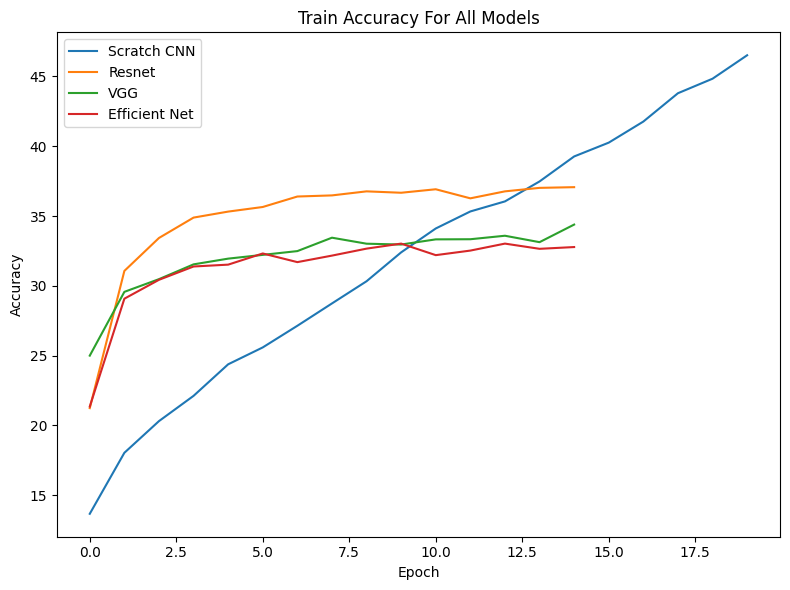

In [69]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_scratchCNN, label='Scratch CNN')
plt.plot(train_acc_resnet, label='Resnet')
plt.plot(train_acc_vgg, label='VGG')
plt.plot(train_accuracy_history, label='Efficient Net')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy For All Models')
plt.legend()
plt.tight_layout()
plt.show()

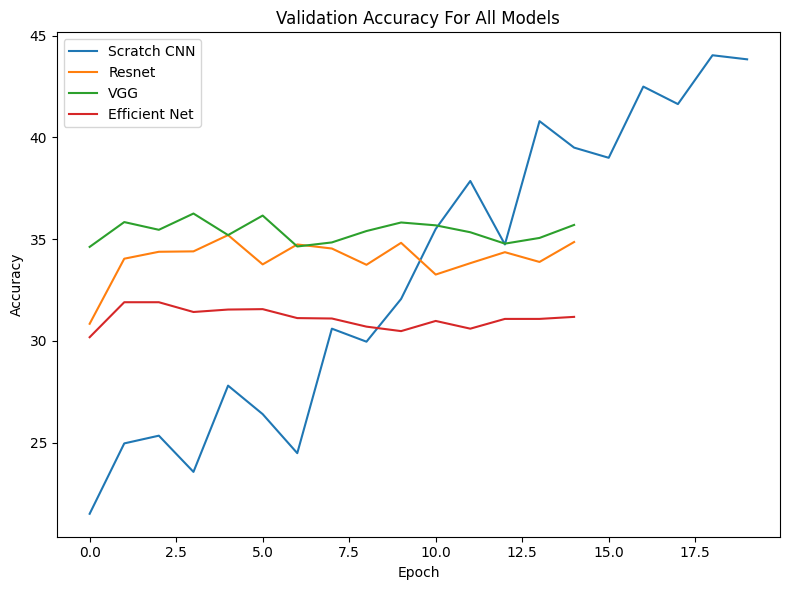

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(val_acc_scratchCNN, label='Scratch CNN')
plt.plot(val_acc_resnet, label='Resnet')
plt.plot(val_acc_vgg, label='VGG')
plt.plot(val_accuracy_history, label='Efficient Net')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy For All Models')
plt.legend()
plt.tight_layout()
plt.show()